In [2]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from sklearn.preprocessing import RobustScaler
import warnings
warnings.filterwarnings(action='ignore')
from statsmodels.formula.api import ols

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

import plotly.express as px
import plotly.graph_objects as go # 객체지향적으로 plotly 사용하기

%matplotlib inline
mpl.rcParams['axes.unicode_minus'] = False

In [3]:
plt.rcParams["font.family"] = 'NanumSquareRoundOTF'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (14,4)

# 01. 데이터 전처리

### 데이터 불러오기

필요 없는 컬럼은 csv에서 미리 삭제해 저장함

In [4]:
df = pd.read_csv('../Data/data_adjsut/train_adjust.csv')

In [5]:
df.shape

(59199, 38)

### 결측치 처리

---

#### 건물은 있는데 건물면적, 건물연면적, 토지면적이 0인 데이터들이 많다. 관찰되지 않은 것일까?
#### 건폐율, 용적률을 생각하면서 면적 관련 데이터의 null값을 최대한 채워보자.

01. 건축면적과 층수 데이터가 있는데 건물연면적, 토지면적이 둘다 없으면 => 
02. 건축면적 데이터는 있는데, 토지면적이 없다면 => 토지면적 = 건축면적
03. 건물연면적, 토지면적, 건축면적 모두 없는데 건물채수가 있다면 중간값?


* 지상, 지하 층수가 모두 0인 데이터 = 97개 

In [6]:
df.isnull().sum()

id                          0
dt_of_fr                    0
bldng_us                27677
bldng_archtctr          27665
bldng_cnt                   0
bldng_ar                    0
ttl_ar                      0
lnd_ar                      0
dt_of_athrztn           27581
ttl_grnd_flr            10210
ttl_dwn_flr             11005
bldng_us_clssfctn       29343
tmprtr                     13
prcpttn                 53629
wnd_spd                    33
wnd_drctn                 221
hmdt                       22
jmk                         0
rgnl_ar_nm               1491
rgnl_ar_nm2              1491
lnd_us_sttn_nm           1776
rd_sd_nm                 1491
emd_nm                      4
hm_cnt                    701
fr_sttn_dstnc               0
bldng_ar_prc            21895
fr_wthr_fclt_dstnc          0
fr_mn_cnt                  41
mlt_us_yn                   0
cctv_dstnc                  0
cctv_in_100m                0
fr_wthr_fclt_in_100m        0
tbc_rtl_str_dstnc           0
sft_emrgnc

In [7]:
# 지하 층 수 null은 평균 0.13... 이므로 0으로 채움
df['ttl_dwn_flr'] = df['ttl_dwn_flr'].fillna(0)

# 화재 여부 string -> int
df['fire_yes'] = df['fr_yn'].replace({'N':0,'Y':1})


# 화재 날짜
df['year'] = pd.to_datetime(df['dt_of_fr']).dt.year
df['month'] = pd.to_datetime(df['dt_of_fr']).dt.month
df['date'] = pd.to_datetime(df['dt_of_fr']).dt.day
df['hour'] = pd.to_datetime(df['dt_of_fr']).dt.hour
df['minute'] = pd.to_datetime(df['dt_of_fr']).dt.minute
df['dayofweek'] = pd.to_datetime(df['dt_of_fr']).dt.day_name()

# df['year-month'] = df['dt_of_fr'].apply(lambda x: x[:7])
# df.drop(['dt_of_fr'], axis= 1, inplace=True)

In [8]:
# 주소

df[(df['emd_nm'].isnull()) | (df['emd_nm'] == 'nan')]['emd_nm']

9165     NaN
15380    NaN
32671    NaN
36516    NaN
Name: emd_nm, dtype: object

In [9]:
address = df.drop([9165, 15380, 32671, 36516], axis=0)
# df = df.drop([9165, 15380, 32671, 36516], axis=0)

address['시도'] = np.nan
address['시군구'] = np.nan
address['구시동면읍'] = np.nan

address['시도'] = address['emd_nm'].apply(lambda x: str(x).split()[0])
address['시군구'] = address['emd_nm'].apply(lambda x: str(x).split()[1][:3])
address['구시동면읍'] = address['emd_nm'].apply(lambda x: str(x).split()[2])
# 창원시는 따로
address.loc[address['시군구'].apply(lambda x: len(x) > 3), '구시동면읍'] = address['emd_nm'].apply(lambda x: str(x).split()[1][3:])

address[['emd_nm', '시도', '시군구', '구시동면읍']].sample()



df['시도'] = address['시도']
df['시군구'] = address['시군구']
df['구시동면읍'] = address['구시동면읍']
df['주소'] = address['시도'] + ' ' + address['시군구'] + ' ' + address['구시동면읍']

data = pd.DataFrame(df.groupby('시군구')['fire_yes'].sum().reset_index())
data = data.sort_values('fire_yes', ascending=False)

In [10]:
print('건물채수가 0인 데이터: ', len(df[df['bldng_cnt'] <= 0]), '개')
print('건축면적이 0인 데이터: ', len(df[df['bldng_ar'] == 0]), '개')
print('건물연면적 0인 데이터: ', len(df[df['ttl_ar'] == 0]), '개')
print('토지면적이 0인 데이터: ', len(df[df['lnd_ar'] == 0]), '개')        
print('지상 층수 데이터 없는 데이터: ', len(df[df['ttl_grnd_flr'].isnull()]), '개')
print('지하 층수 데이터 없는 데이터: ', len(df[df['ttl_dwn_flr'].isnull()]), '개')
print('지상 층수가 0 : ', len(df[df['ttl_grnd_flr'] == 0]), '개')
print('지하 층수가 0: ', len(df[df['ttl_dwn_flr'] == 0.0]), '개')

건물채수가 0인 데이터:  0 개
건축면적이 0인 데이터:  9660 개
건물연면적 0인 데이터:  8426 개
토지면적이 0인 데이터:  25569 개
지상 층수 데이터 없는 데이터:  10210 개
지하 층수 데이터 없는 데이터:  0 개
지상 층수가 0 :  103 개
지하 층수가 0:  55584 개


In [62]:
# 지상 층수 null 데이터 없애기

a = df[df['ttl_grnd_flr'].isnull()][['bldng_ar', 'ttl_ar', 'lnd_ar', 'ttl_grnd_flr', 'ttl_dwn_flr']]
a['ttl_grnd_flr'] = a.apply(lambda row : row['bldng_ar'] == 0 : row['ttl_grnd_flr'] = 0, row[])

,bldng_ar,ttl_ar,lnd_ar,ttl_grnd_flr,ttl_dwn_flr
4,0.00,0.00,0.0,NaN,0.0
13,59.10,59.10,327.0,NaN,0.0
18,100.35,94.00,468.0,NaN,0.0
47,0.00,0.00,0.0,NaN,0.0
57,103.89,103.89,596.0,NaN,0.0
68,0.00,0.00,0.0,NaN,0.0
85,0.00,0.00,0.0,NaN,0.0
89,0.00,0.00,0.0,NaN,0.0
96,0.00,0.00,0.0,NaN,0.0
105,0.00,0.00,0.0,NaN,0.0


In [72]:
df['ttl_grnd_flr'] = df.apply(lambda row:
                              row['ttl_ar']
                              if row['ttl_ar'] == 0 or row['bldng_ar'] == 0
                              else row['ttl_ar'] / row['bldng_ar'], axis=1)

In [77]:
df.to_csv('train_hanseul.csv', index=False)

In [30]:
width_list = ['bldng_cnt', 'bldng_ar', 'ttl_ar', 'lnd_ar', 'ttl_grnd_flr', 'ttl_dwn_flr']
width = df['width_list']
width.corr()

,bldng_cnt,bldng_ar,ttl_ar,lnd_ar,ttl_grnd_flr,ttl_dwn_flr
bldng_cnt,1.000000,0.530414,0.189012,0.443320,0.454254,0.395687
bldng_ar,0.530414,1.000000,0.329309,0.604804,0.350215,0.420066
ttl_ar,0.189012,0.329309,1.000000,0.230771,0.289221,0.258168
lnd_ar,0.443320,0.604804,0.230771,1.000000,0.186991,0.384872
ttl_grnd_flr,0.454254,0.350215,0.289221,0.186991,1.000000,0.698365
ttl_dwn_flr,0.395687,0.420066,0.258168,0.384872,0.698365,1.000000


In [33]:
from sklearn.decomposition import PCA

In [34]:
pca = PCA(n_components=2)
score = pca.fit_transform(width.iloc[:, 1:])
pca.explained_variance_ratio_ # array([0.99809123, 0.00173592]) 첫번째 차원이 99퍼 설명하고 두번째 차원이 0.0001 을 설명함

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [12]:
df['bldng_ar'].mean()

633.5627395361407

In [23]:
df['bldng_ar'].max()

572897.954999999

In [24]:
df['bldng_ar'].min()

0.0

In [31]:
res = ols('ttl_grnd_flr ~ bldng_ar + ttl_ar + lnd_ar + ttl_dwn_flr', df).fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           ttl_grnd_flr   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                 1.342e+04
Date:                Sun, 03 Nov 2019   Prob (F-statistic):               0.00
Time:                        13:47:57   Log-Likelihood:            -1.8813e+05
No. Observations:               48989   AIC:                         3.763e+05
Df Residuals:                   48984   BIC:                         3.763e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.5492      0.051     30.135      0.000       1.448       1.650
bldng_ar        0.0002   6.75e-06     33.383      0.000       0.000       0.000
ttl_ar        2.09e-05   6.32e-07     33.055      0.000    1.97e-05    2.21e-05
lnd_ar      -1.285e-06   2.75e-08    -46.663      0.000   -1.34e-06   -1.23e-06
ttl_dwn_flr    11.2086      0.058    193.460      0.000      11.095      11.322
==============================================================================
Omnibus:                    98167.512   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        440253873.217
Skew:                          16.309   Prob(JB):                         0.00
Kurtosis:                     466.270   Cond. No.                     2.75e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.75e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<br>

#### 토지면적, 연면적, 건축면적 모두 있는 데이터를 나눠서 Train, Test 해보자

In [71]:
# 눌값 없는 데이터의 상관계수 체크
width_drop = width[(width['bldng_ar'] != 0) & (width['ttl_ar'] != 0) &(width['lnd_ar'] != 0)]
width_drop = width_drop.dropna()
width_drop.corr()


,bldng_cnt,bldng_ar,ttl_ar,lnd_ar,ttl_grnd_flr,ttl_dwn_flr
bldng_cnt,1.000000,0.766720,0.716781,0.611297,0.597042,0.611975
bldng_ar,0.766720,1.000000,0.914673,0.775034,0.557669,0.692330
ttl_ar,0.716781,0.914673,1.000000,0.883425,0.667479,0.804471
lnd_ar,0.611297,0.775034,0.883425,1.000000,0.440195,0.665198
ttl_grnd_flr,0.597042,0.557669,0.667479,0.440195,1.000000,0.735390
ttl_dwn_flr,0.611975,0.692330,0.804471,0.665198,0.735390,1.000000


아웃라이어 제거

In [83]:
def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((ys > upper_bound) | (ys < lower_bound))


width_drop.apply(lambda col : outliers_iqr(col))

TypeError: ("can't multiply sequence by non-int of type 'float'", 'occurred at index dt_of_fr')

In [82]:
res = ols('bldng_ar ~ bldng_cnt + ttl_ar + lnd_ar + ttl_grnd_flr + ttl_dwn_flr', df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               bldng_ar   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                 1.048e+04
Date:                Fri, 01 Nov 2019   Prob (F-statistic):               0.00
Time:                        21:33:35   Log-Likelihood:            -5.0316e+05
No. Observations:               48989   AIC:                         1.006e+06
Df Residuals:                   48983   BIC:                         1.006e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -1280.6454     36.837    -34.765      0.000   -1352.846   -1208.445
bldng_cnt      506.1065      6.143     82.393      0.000     494.067     518.146
ttl_ar           0.0165      0.000     42.343      0.000       0.016       0.017
lnd_ar           0.0016   1.66e-05     95.452      0.000       0.002       0.002
ttl_grnd_flr    33.9395      2.882     11.776      0.000      28.291      39.588
ttl_dwn_flr    460.1761     47.776      9.632      0.000     366.535     553.817
==============================================================================
Omnibus:                   148582.663   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      18685963048.660
Skew:                          45.180   Prob(JB):                         0.00
Kurtosis:                    3027.268   Cond. No.                     3.59e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.59e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [21]:
# a['b_l'] = width['bldng_ar'].isnull()
# plt.figure(figsize = (15,15))
# sns.heatmap(data = a.corr(), annot=True, fmt = '.2f', linewidths=.2, cmap='Blues' )

In [22]:
#plt.figure(figsize = (10,10))
#sns.heatmap(data = width_drop.corr(), annot=True, fmt = '.2f', linewidths=.2, cmap='Blues' )
width_drop.corr()

,bldng_cnt,bldng_ar,ttl_ar,lnd_ar,ttl_grnd_flr,ttl_dwn_flr
bldng_cnt,1.000000,0.745936,0.689632,0.584136,0.594058,0.611975
bldng_ar,0.745936,1.000000,0.912741,0.769379,0.557667,0.692329
ttl_ar,0.689632,0.912741,1.000000,0.881332,0.667423,0.804471
lnd_ar,0.584136,0.769379,0.881332,1.000000,0.440128,0.665198
ttl_grnd_flr,0.594058,0.557667,0.667423,0.440128,1.000000,0.735390
ttl_dwn_flr,0.611975,0.692329,0.804471,0.665198,0.735390,1.000000


<br><br><br>
#### 02. 결측치 상황을 나눠 예상 값 계산하기

<br>

01. 빌딩카운트만 있음 <br>
    따로 빼서 살펴보거나 제거

02. 빌딩 cnt, ar 있음 <br>
    ttl_ar, lnd_ar

03. b_ar, ttl_ar <br>
    -> lnd_ar

04. ttl_ar
    -> b_ar, lnd_ar <br>

05. b_ar, lnd_ar <br>
    -> ttl_ar

06. lnd_ar <br>
    -> b_ar, ttl_ar

    

In [24]:
# 총 층수
width['tt_flr'] = width['ttl_grnd_flr'] + width['ttl_dwn_flr']

In [83]:
for x in tDB[tDB['lnd_ar2'] == 0].index:
    tDB['lnd_ar2'][x] = tDB['bldng_ar'][x]
print('토지면적이 0인 데이터: ', len(tDB[tDB['lnd_ar2'] == 0.0]), '개')


for x in tDB[tDB['ttl_ar2'] == 0].index:
    tDB['ttl_ar2'][x] = tDB['bldng_ar'][x] * tDB['tt_flr'][x]
    
print('연면적이 0인 데이터: ', len(tDB[tDB['ttl_ar2'] == 0.0]), '개')

토지면적이 0인 데이터:  8992 개
연면적이 0인 데이터:  803 개


In [84]:
a = tDB[['bldng_cnt','bldng_ar', 'ttl_ar', 'lnd_ar', 'ttl_grnd_flr', 'ttl_dwn_flr']]
a.iloc[:,:].corr()

,bldng_cnt,bldng_ar,ttl_ar,lnd_ar,ttl_grnd_flr,ttl_dwn_flr
bldng_cnt,1.000000,0.530414,0.189012,0.443320,0.454254,0.472871
bldng_ar,0.530414,1.000000,0.329309,0.604804,0.350215,0.422405
ttl_ar,0.189012,0.329309,1.000000,0.230771,0.289221,0.257870
lnd_ar,0.443320,0.604804,0.230771,1.000000,0.186991,0.385779
ttl_grnd_flr,0.454254,0.350215,0.289221,0.186991,1.000000,0.698330
ttl_dwn_flr,0.472871,0.422405,0.257870,0.385779,0.698330,1.000000


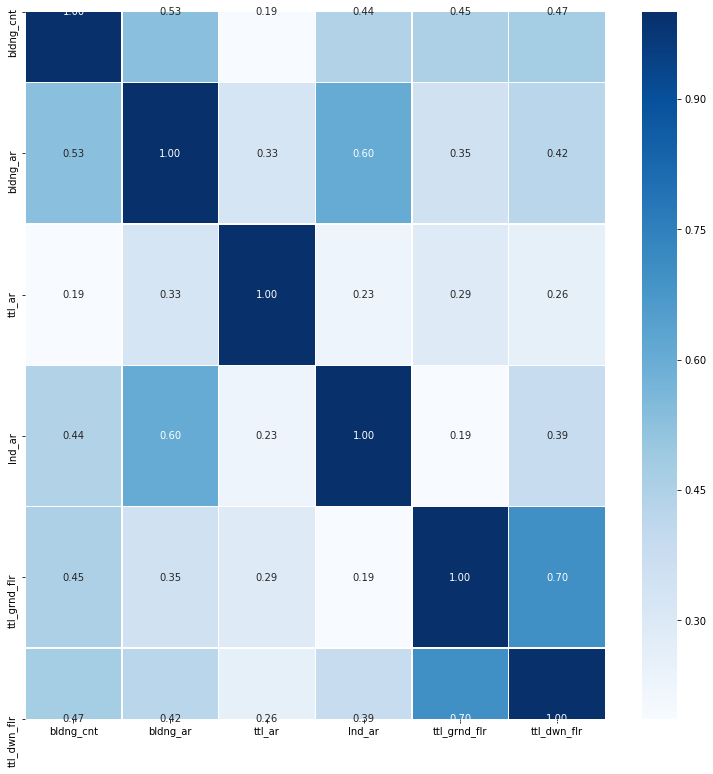

In [85]:
plt.figure(figsize=(13,13))
sns.heatmap(data = a.iloc[:,:].corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')



### 2. 차원 축소 - PCA 사용

- 건물 수 / 건축면적 => 건물 밀집도

(건물 수, 건축 면적 안쓰기)

In [95]:
from sklearn.preprocessing import StandardScaler

### 표준화

In [96]:
scale = StandardScaler()

In [98]:
x = scale.fit_transform(tDB.iloc[:, :])

ValueError: could not convert string to float: '2015-10-03 02:33:46'

In [93]:
tDB['dencity'] = tDB['bldng_ar'] / tDB['bldng_cnt']
tDB['dencity']

0         37.620000
1        240.606667
2         11.765000
3         85.725000
4          0.000000
            ...    
59194    167.670000
59195     28.690000
59196     63.160000
59197      0.000000
59198     45.890000
Name: dencity, Length: 59199, dtype: float64

In [130]:
voidplace = tDB[(tDB['bldng_ar'] == 0) & (tDB['ttl_ar'] == 0) & (tDB['lnd_ar'] ==0)]
voidplace[['id', 'bldng_archtctr', 'bldng_ar', 'ttl_grnd_flr', 'ttl_dwn_flr']]
voidplace

1386836

### b. 빌딩 용도 처리

In [59]:
print('카테고리:   ', tDB['bldng_us'].unique())
print('len:   ', len(tDB['bldng_us'].unique()))

카테고리:    [nan '업무시설' '단독주택' '위험물저장및처리시설' '공동주택' '제1종근린생활시설' '공장' '제2종근린생활시설'
 '노유자시설' '운동시설' '동.식물 관련시설' '창고시설' '의료시설' '위락시설' '자동차관련시설' '종교시설' '근린생활시설'
 '분뇨.쓰레기처리시설' '숙박시설' '교육연구시설' '발전시설' '관광휴게시설' '판매시설' '수련시설' '문화및집회시설'
 '묘지관련시설' '방송통신시설' '장례식장' '운수시설' '교정및군사시설' '교육연구및복지시설' '파출소' '판매및영업시설'
 '시장' '공공용시설']
len:    35


### c. 빌딩 자재

In [60]:
print('카테고리:    ', tDB['bldng_archtctr'].unique())
print('len:   ', len(tDB['bldng_archtctr'].unique()))

카테고리:     [nan '철근콘크리트구조' '블록구조' '벽돌구조' '경량철골구조' '일반목구조' '일반철골구조' '기타구조' '강파이프구조'
 '조적구조' '석구조' '기타조적구조' '통나무구조' '철골콘크리트구조' '철골철근콘크리트구조' '기타강구조'
 '프리케스트콘크리트구조' '목구조' '기타콘크리트구조']
len:    19


## 문자형 데이터 -> digit화

### ** 건물채 수, 건물건축면적, 건물연면적, 토지면적이 서로 큰 관계성을 가지고 있으므로 차원 축소를 시도해 본다.

In [95]:
plt.figure(figsize=(13,13))
sns.heatmap(data = .iloc[:,1:].corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

NameError: name 'df_y' is not defined

<Figure size 936x936 with 0 Axes>

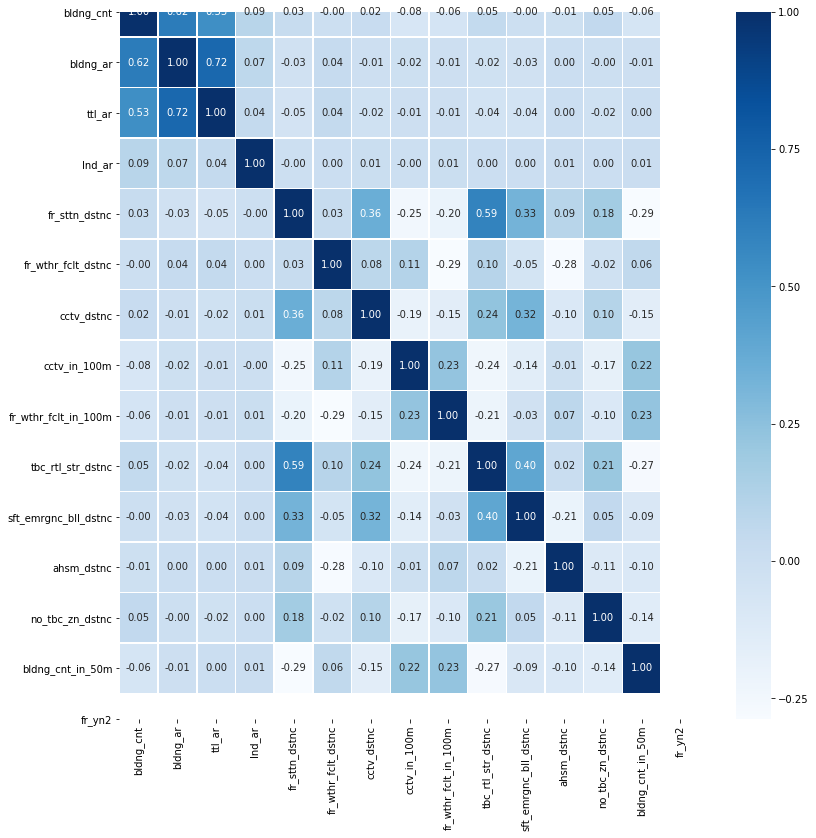

In [85]:
plt.figure(figsize=(13,13))
sns.heatmap(data = tDB_n.iloc[:,1:].corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

# Yearly 비교


(11000, 12500)

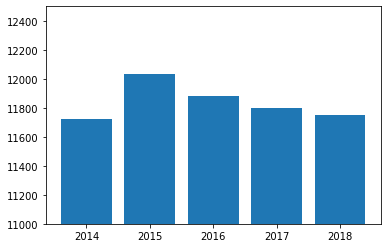

In [31]:
y_count = df.groupby('year').count().reset_index()[['year', 'id']]
y_count = y_count.rename(columns = {'id':'count'})
plt.bar(x = 'year', height='count', data = y_count)
plt.ylim(11000, 12500)

---

# Monthly 비교
> 계절별 비교로 나눠 할 수 있겠음

(4400, 5500)

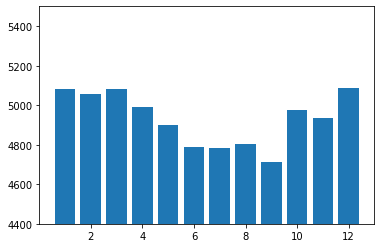

In [30]:
m_count = df.groupby('month').count().reset_index()[['month', 'id']]
m_count = m_count.rename(columns = {'id':'count'})
plt.bar(x = 'month', height='count', data = m_count)
plt.ylim(4400, 5500)

---
# 날짜별 비교
 
 > 요일별 비교가 더 나을 듯

<BarContainer object of 31 artists>

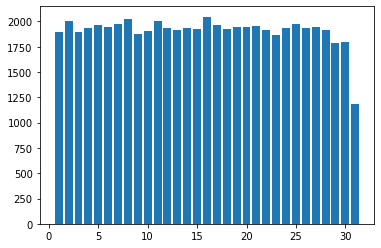

In [34]:
d_count = df.groupby('date').count().reset_index()[['date', 'id']]
d_count = d_count.rename(columns = {'id':'count'})
plt.bar(x = 'date', height='count', data = d_count)

---
# 시간대별 비교

In [37]:
a = df['hour'].reset_index()
a['hour'] = a['hour'].apply(lambda x : x[:2])
time_line = sorted(a['hour'])
plt.hist(time_line, bins = 24)
plt.ylim(2000, 2750)

TypeError: 'int' object is not subscriptable